<a href="https://colab.research.google.com/github/nourdouha/codealpha_tasks/blob/main/task%201%20_%20credit_scoring_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
!pip install datasist

In [64]:
!pip install category_encoders

In [65]:
# Packages for EDA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from datasist.structdata import detect_outliers
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
import category_encoders as ce
import re

# Modeling and evaluation
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import (
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    StackingClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import joblib

# Packages options
sns.set(rc={'figure.figsize': [14, 7]}, font_scale=1.2) # Standard figure size for all
np.seterr(divide='ignore', invalid='ignore', over='ignore') ;

import warnings
warnings.filterwarnings("ignore")

In [66]:
!kaggle datasets download -d parisrohan/credit-score-classification

Dataset URL: https://www.kaggle.com/datasets/parisrohan/credit-score-classification
License(s): CC0-1.0
credit-score-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [67]:
!unzip credit-score-classification.zip -d ./credit-score-classification

Archive:  credit-score-classification.zip
replace ./credit-score-classification/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [68]:
df = pd.read_csv("/content/credit-score-classification/train.csv",low_memory=False)

In [69]:
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [70]:
df.shape

(100000, 28)

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

In [72]:
df.describe()

,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month
count,84998.000000,100000.000000,100000.00000,100000.000000,100000.000000,98035.000000,100000.000000,100000.000000
mean,4194.170850,17.091280,22.47443,72.466040,21.068780,27.754251,32.285173,1403.118217
std,3183.686167,117.404834,129.05741,466.422621,14.860104,193.177339,5.116875,8306.041270
min,303.645417,-1.000000,0.00000,1.000000,-5.000000,0.000000,20.000000,0.000000
25%,1625.568229,3.000000,4.00000,8.000000,10.000000,3.000000,28.052567,30.306660
50%,3093.745000,6.000000,5.00000,13.000000,18.000000,6.000000,32.305784,69.249473
75%,5957.448333,7.000000,7.00000,20.000000,28.000000,9.000000,36.496663,161.224249
max,15204.633333,1798.000000,1499.00000,5797.000000,67.000000,2597.000000,50.000000,82331.000000


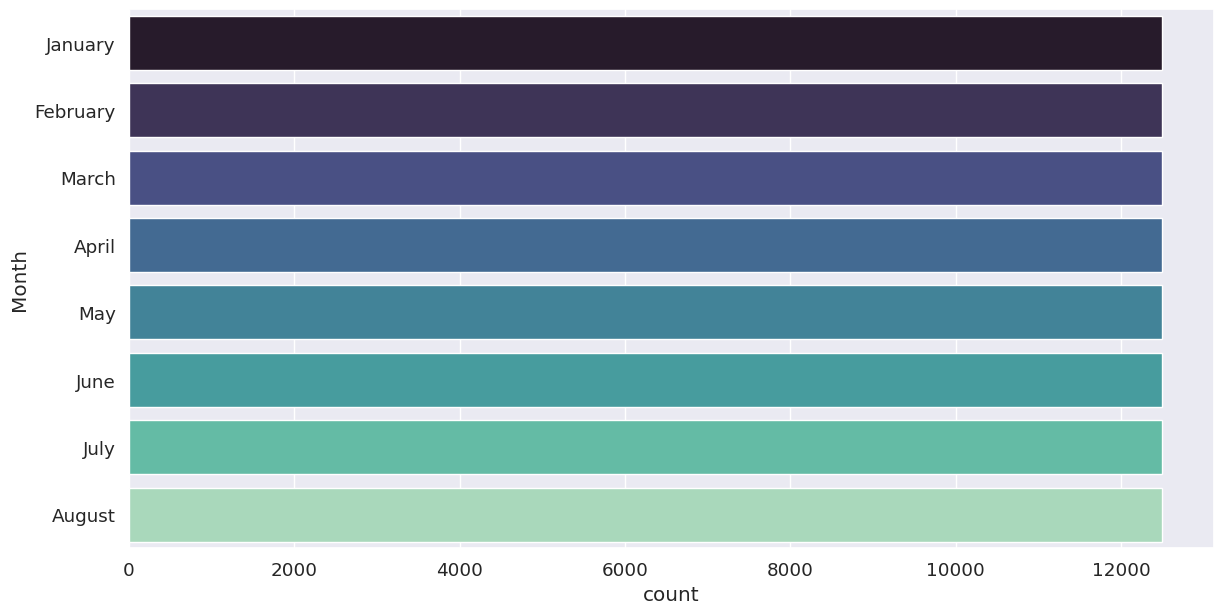

In [73]:
sns.countplot(df['Month'],palette="mako");

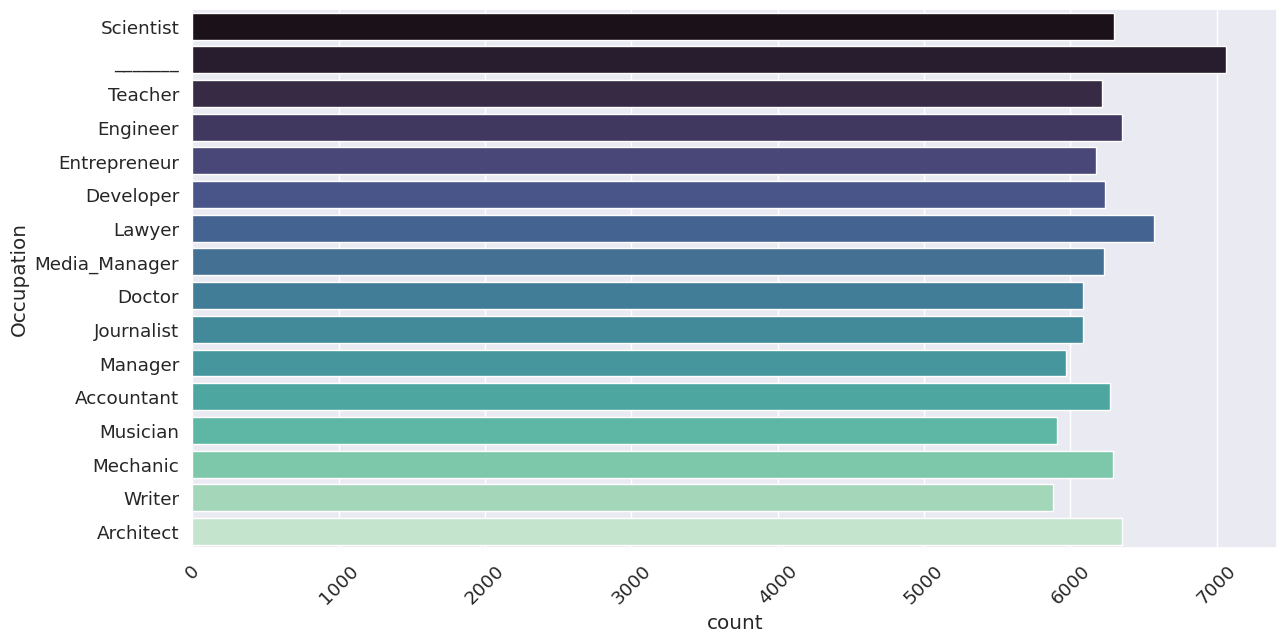

In [74]:
sns.countplot(df['Occupation'],palette="mako");
plt.xticks(rotation=45);

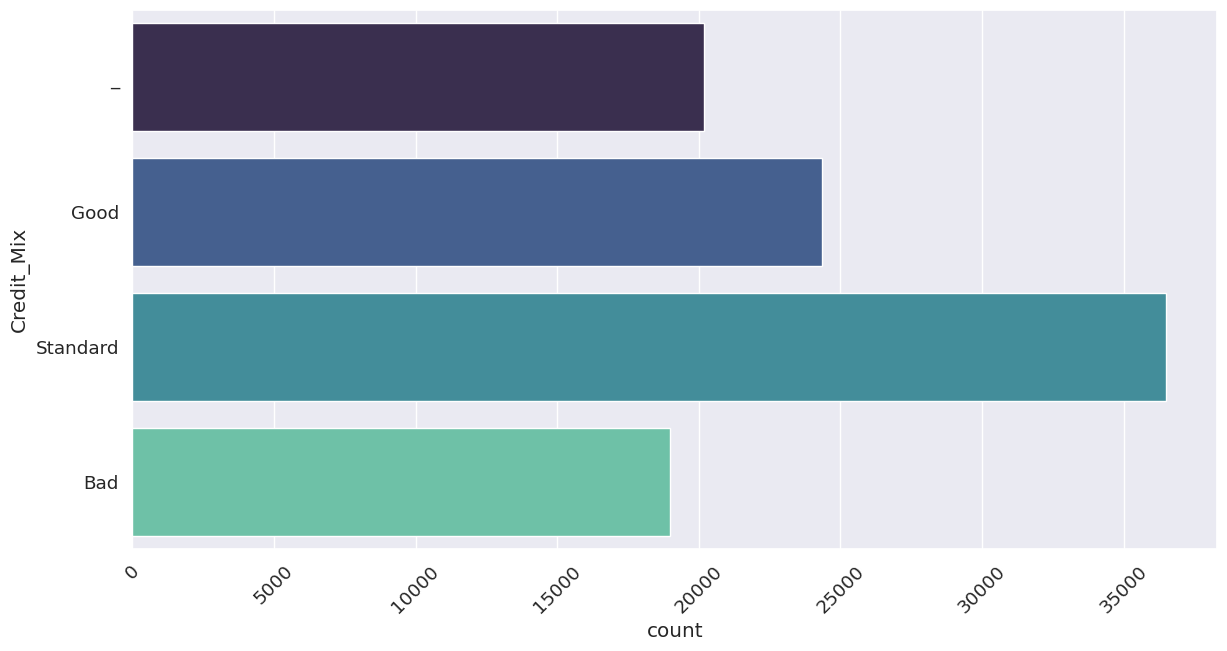

In [75]:
sns.countplot(df['Credit_Mix'],palette="mako");
plt.xticks(rotation=45);

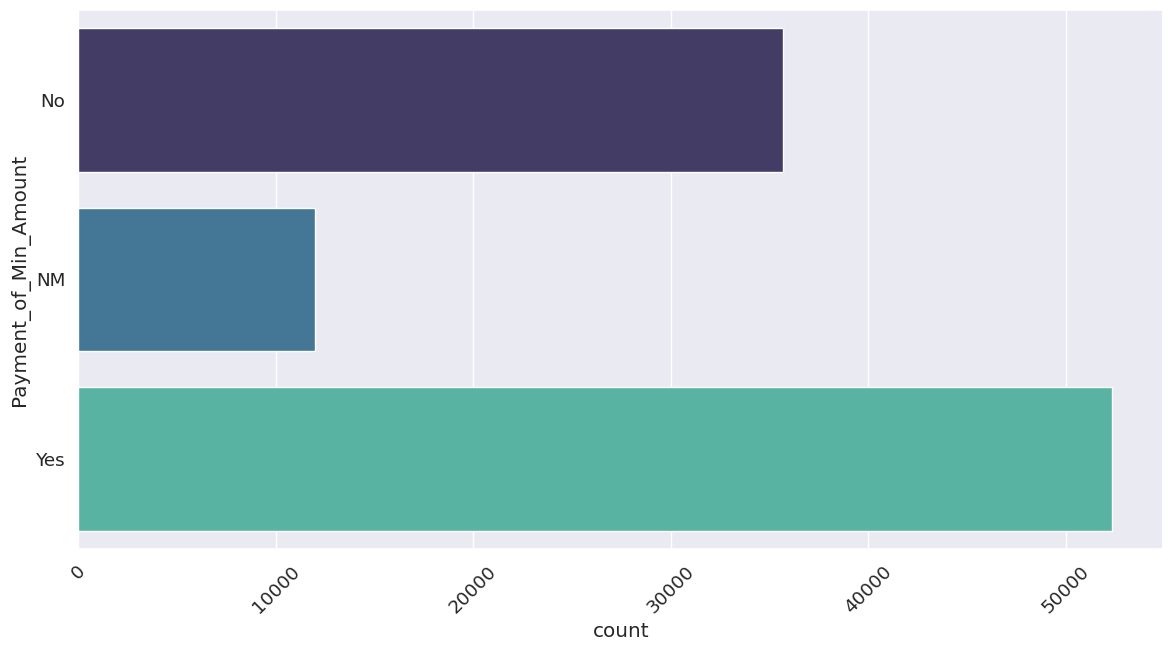

In [76]:
sns.countplot(df['Payment_of_Min_Amount'],palette="mako");
plt.xticks(rotation=45);

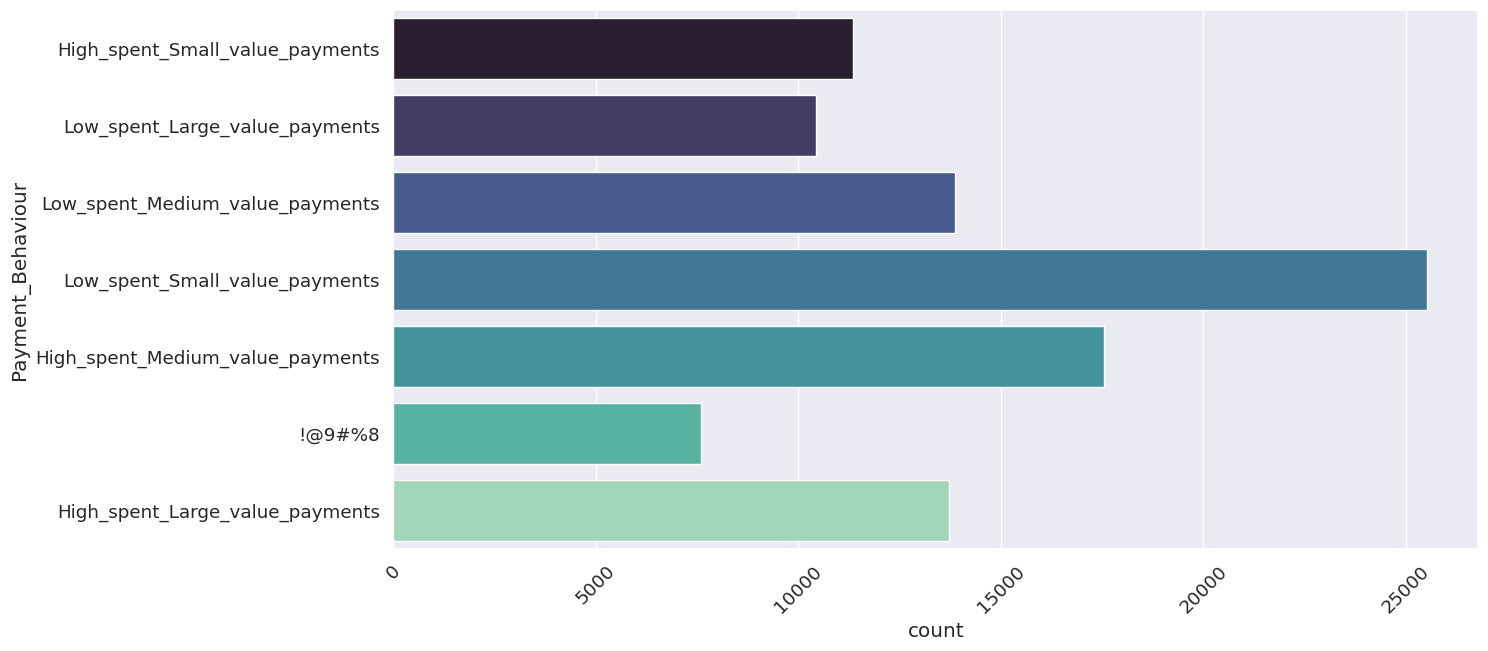

In [77]:
sns.countplot(df['Payment_Behaviour'],palette="mako");
plt.xticks(rotation=45);

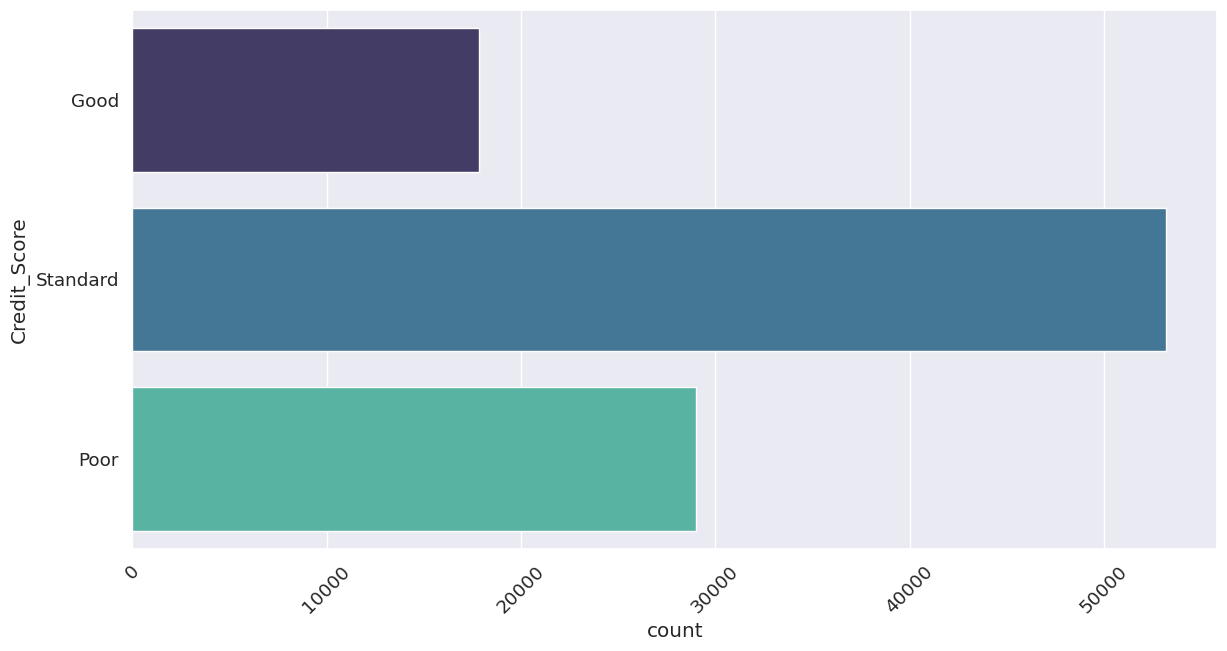

In [78]:
sns.countplot(df['Credit_Score'],palette="mako");
plt.xticks(rotation=45);

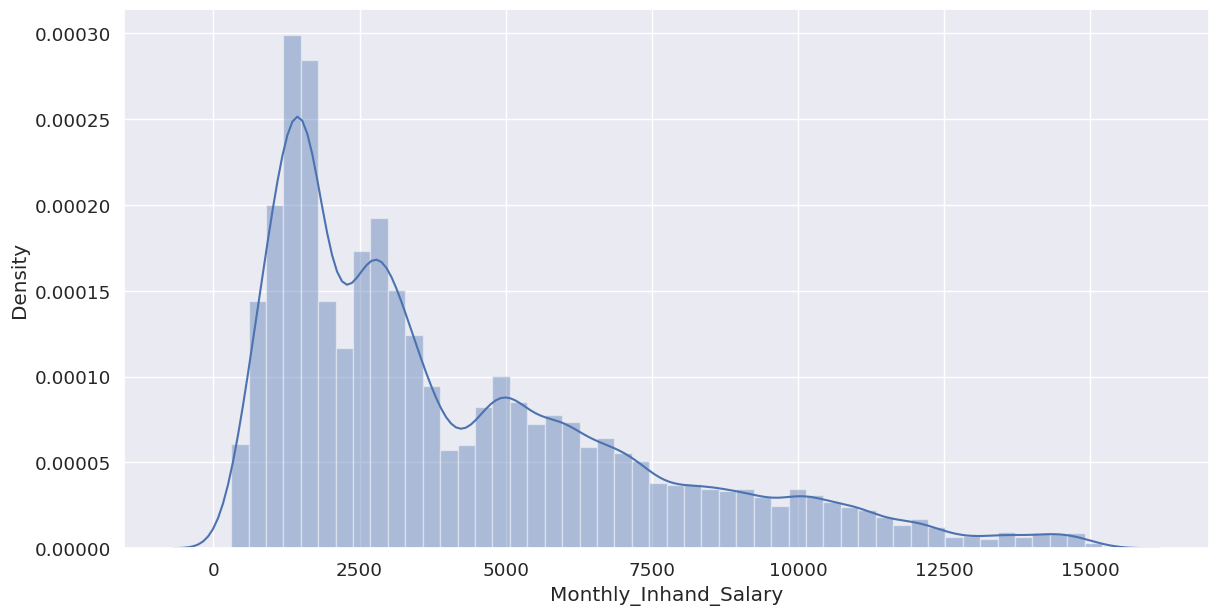

In [79]:
sns.distplot(df['Monthly_Inhand_Salary']);

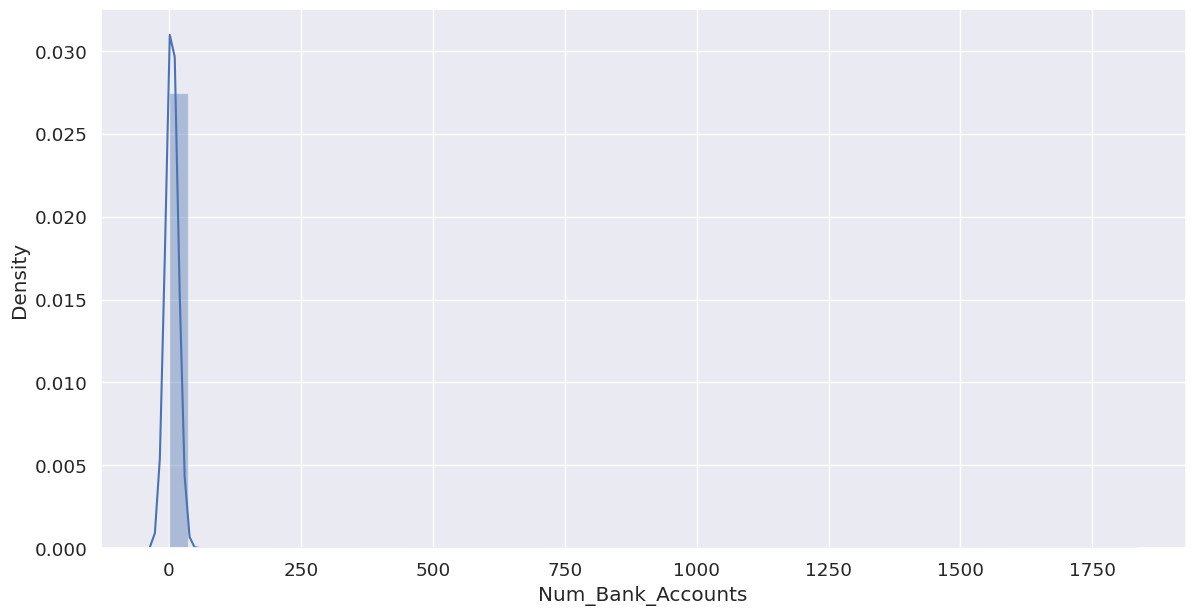

In [80]:
sns.distplot(df['Num_Bank_Accounts']);

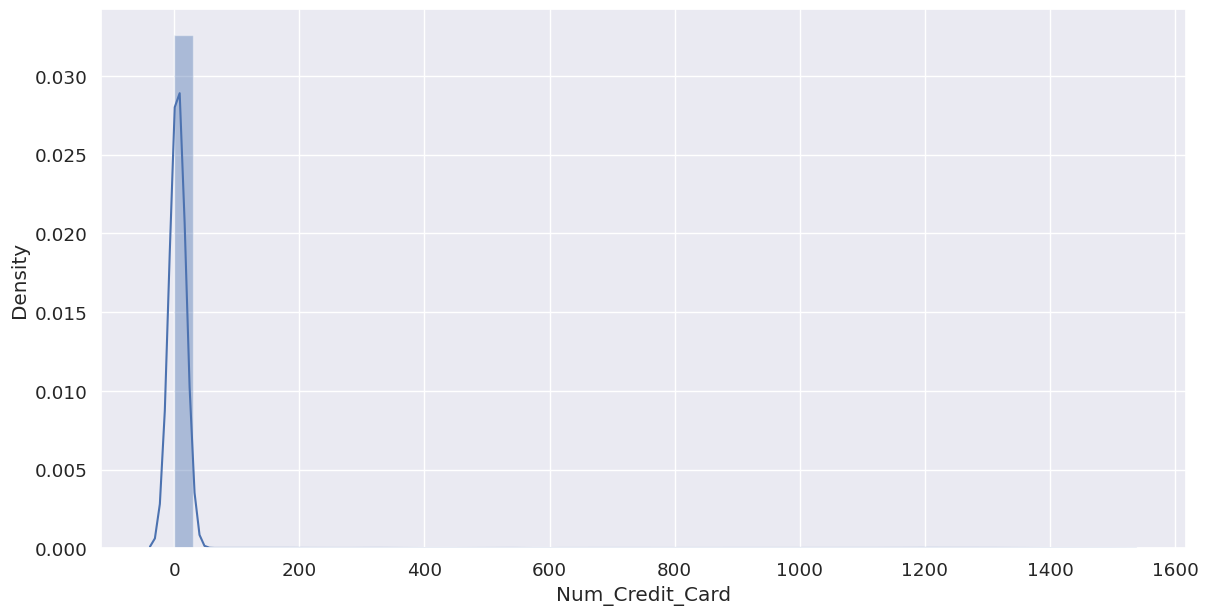

In [81]:
sns.distplot(df['Num_Credit_Card']);

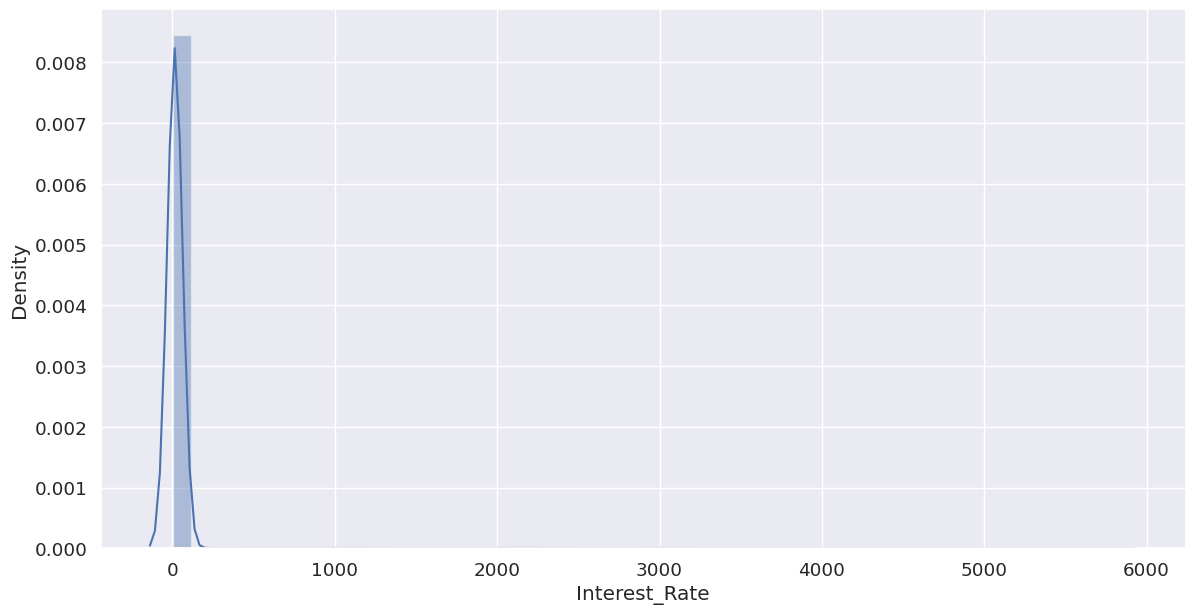

In [82]:
sns.distplot(df['Interest_Rate']);

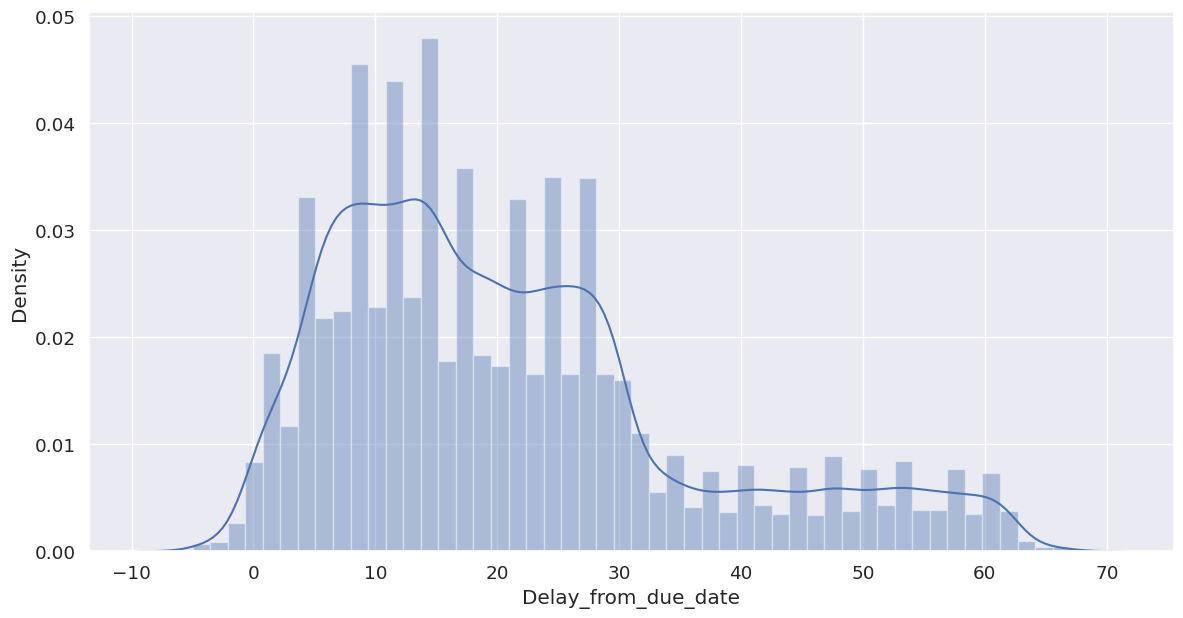

In [83]:
sns.distplot(df['Delay_from_due_date']);

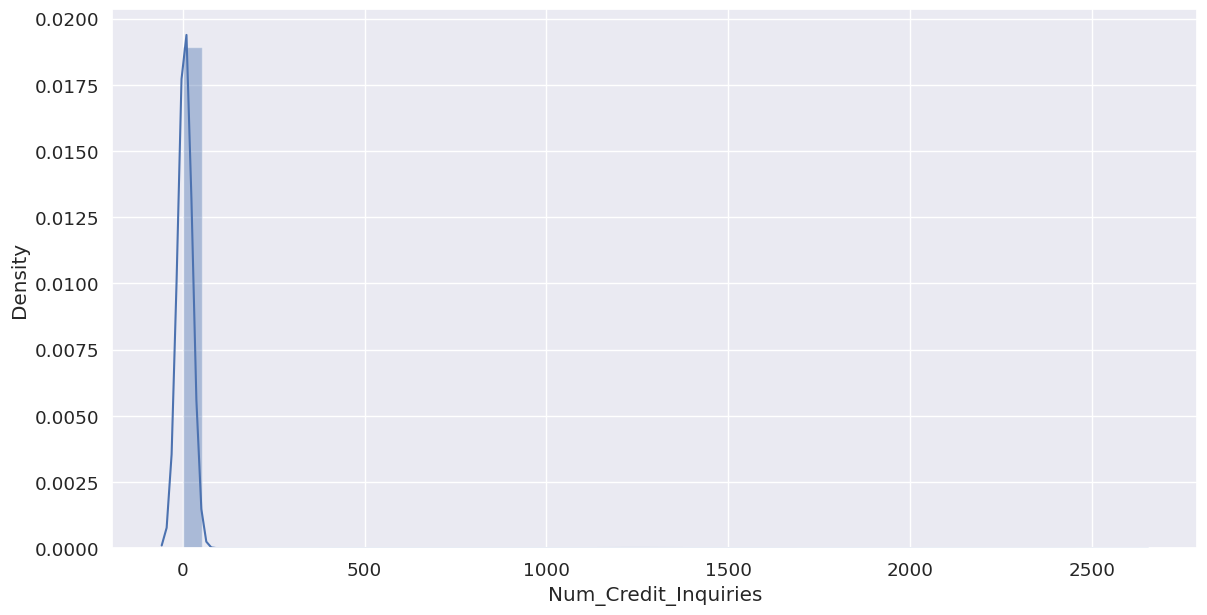

In [84]:
sns.distplot(df['Num_Credit_Inquiries']);

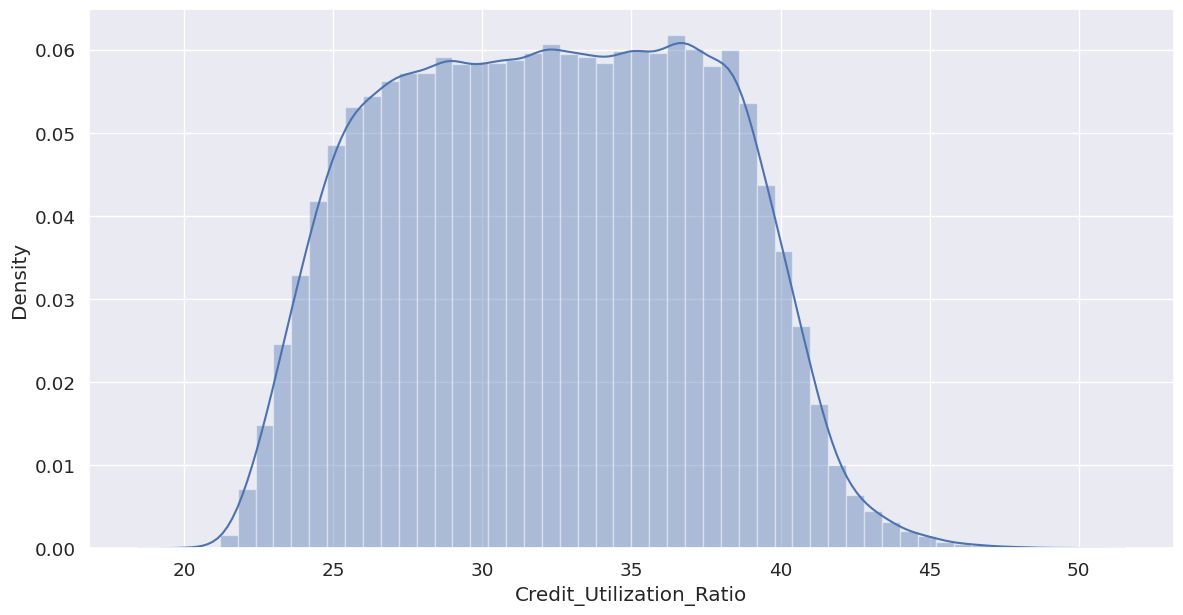

In [85]:
sns.distplot(df['Credit_Utilization_Ratio']);

In [86]:
df['Type_of_Loan'].value_counts().head(10)

,count
Type_of_Loan,
Not Specified,1408
Credit-Builder Loan,1280
Personal Loan,1272
Debt Consolidation Loan,1264
Student Loan,1240
Payday Loan,1200
Mortgage Loan,1176
Auto Loan,1152
Home Equity Loan,1136


In [87]:
del df['ID'] # Identification
del df['Name'] # Name of client
del df['SSN'] # SSN (social security number of a person

In [88]:
N_to_fix = ['Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Amount_invested_monthly', 'Outstanding_Debt' , 'Monthly_Balance']

In [89]:
def fix_nums(num):
    try :
        return float(num.replace("_",""))
    except :
        return np.nan

In [90]:
for col in N_to_fix :
    df[col] = df[col].apply(fix_nums)

In [91]:
for i in df['Type_of_Loan'].value_counts().head(9).index[1:] :
    df[i] = df['Type_of_Loan'].str.contains(i)

del df['Type_of_Loan']

In [92]:
df['Num_Bank_Accounts'] = df['Num_Bank_Accounts'].apply(lambda x :abs (x))

In [93]:
df['Num_Credit_Card'].replace(0,1,inplace=True)

In [94]:
def History_age(age):
    try :
        years = int("".join(re.findall('[0-9]',''.join(age.split("and")[0]))))
        month = int("".join(re.findall('[0-9]',''.join(age.split("and")[1]))))
        return years*12 + month
    except :
        return np.nan

In [95]:
df['Payment_of_Min_Amount'].replace("NM","No",inplace=True)

In [96]:
df['Payment_of_Min_Amount'].value_counts()

,count
Payment_of_Min_Amount,
Yes,52326
No,47674


In [97]:
df['Payment_Behaviour']= df['Payment_Behaviour'].replace("!@9#%8",np.nan)

In [98]:
df['Payment_Behaviour'].value_counts()

,count
Payment_Behaviour,
Low_spent_Small_value_payments,25513
High_spent_Medium_value_payments,17540
Low_spent_Medium_value_payments,13861
High_spent_Large_value_payments,13721
High_spent_Small_value_payments,11340
Low_spent_Large_value_payments,10425


In [99]:
df['Occupation'].value_counts()

,count
Occupation,
_______,7062
Lawyer,6575
Architect,6355
Engineer,6350
Scientist,6299
Mechanic,6291
Accountant,6271
Developer,6235
Media_Manager,6232


In [100]:
occs = df['Occupation'].value_counts().index[1:]
occs

Index(['Lawyer', 'Architect', 'Engineer', 'Scientist', 'Mechanic',
       'Accountant', 'Developer', 'Media_Manager', 'Teacher', 'Entrepreneur',
       'Doctor', 'Journalist', 'Manager', 'Musician', 'Writer'],
      dtype='object', name='Occupation')

In [101]:
id_ = "CUS_0xb891"
oc = df[df['Customer_ID'] == id_]['Occupation'].mode()[0]
df[df['Customer_ID'] == id_].replace("_______",oc)

,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,...,Monthly_Balance,Credit_Score,Credit-Builder Loan,Personal Loan,Debt Consolidation Loan,Student Loan,Payday Loan,Mortgage Loan,Auto Loan,Home Equity Loan
24,CUS_0xb891,January,54.0,Entrepreneur,30689.89,2612.490833,2,5,4,1.0,...,433.604773,Standard,False,False,False,False,False,False,False,False
25,CUS_0xb891,February,54.0,Entrepreneur,30689.89,2612.490833,2,5,4,1.0,...,409.951812,Standard,False,False,False,False,False,False,False,False
26,CUS_0xb891,March,55.0,Entrepreneur,30689.89,2612.490833,2,5,4,1.0,...,411.427123,Standard,False,False,False,False,False,False,False,False
27,CUS_0xb891,April,55.0,Entrepreneur,30689.89,2612.490833,2,5,4,1.0,...,262.499594,Standard,False,False,False,False,False,False,False,False
28,CUS_0xb891,May,55.0,Entrepreneur,30689.89,2612.490833,2,5,4,1.0,...,359.374916,Standard,False,False,False,False,False,False,False,False
29,CUS_0xb891,June,55.0,Entrepreneur,30689.89,2612.490833,2,5,4,1.0,...,419.880784,Standard,False,False,False,False,False,False,False,False
30,CUS_0xb891,July,55.0,Entrepreneur,30689.89,2612.490833,2,5,4,1.0,...,443.549957,Standard,False,False,False,False,False,False,False,False
31,CUS_0xb891,August,55.0,Entrepreneur,30689.89,2612.490833,2,5,4,-100.0,...,379.216381,Standard,False,False,False,False,False,False,False,False


In [102]:
df['Occupation'].value_counts()

,count
Occupation,
_______,7062
Lawyer,6575
Architect,6355
Engineer,6350
Scientist,6299
Mechanic,6291
Accountant,6271
Developer,6235
Media_Manager,6232


In [103]:
df['Occupation'] = df['Occupation'].replace("_______",df['Occupation'].mode()[0])

In [104]:
df['Occupation'].value_counts()

,count
Occupation,
_______,7062
Lawyer,6575
Architect,6355
Engineer,6350
Scientist,6299
Mechanic,6291
Accountant,6271
Developer,6235
Media_Manager,6232


In [105]:
occs = df['Occupation'].value_counts().index[1:]
occs

Index(['Lawyer', 'Architect', 'Engineer', 'Scientist', 'Mechanic',
       'Accountant', 'Developer', 'Media_Manager', 'Teacher', 'Entrepreneur',
       'Doctor', 'Journalist', 'Manager', 'Musician', 'Writer'],
      dtype='object', name='Occupation')

In [106]:
id_ = "CUS_0xb891"
oc = df[df['Customer_ID'] == id_]['Occupation'].mode()[0]
df[df['Customer_ID'] == id_].replace("_______",oc)

,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,...,Monthly_Balance,Credit_Score,Credit-Builder Loan,Personal Loan,Debt Consolidation Loan,Student Loan,Payday Loan,Mortgage Loan,Auto Loan,Home Equity Loan
24,CUS_0xb891,January,54.0,Entrepreneur,30689.89,2612.490833,2,5,4,1.0,...,433.604773,Standard,False,False,False,False,False,False,False,False
25,CUS_0xb891,February,54.0,Entrepreneur,30689.89,2612.490833,2,5,4,1.0,...,409.951812,Standard,False,False,False,False,False,False,False,False
26,CUS_0xb891,March,55.0,Entrepreneur,30689.89,2612.490833,2,5,4,1.0,...,411.427123,Standard,False,False,False,False,False,False,False,False
27,CUS_0xb891,April,55.0,Entrepreneur,30689.89,2612.490833,2,5,4,1.0,...,262.499594,Standard,False,False,False,False,False,False,False,False
28,CUS_0xb891,May,55.0,Entrepreneur,30689.89,2612.490833,2,5,4,1.0,...,359.374916,Standard,False,False,False,False,False,False,False,False
29,CUS_0xb891,June,55.0,Entrepreneur,30689.89,2612.490833,2,5,4,1.0,...,419.880784,Standard,False,False,False,False,False,False,False,False
30,CUS_0xb891,July,55.0,Entrepreneur,30689.89,2612.490833,2,5,4,1.0,...,443.549957,Standard,False,False,False,False,False,False,False,False
31,CUS_0xb891,August,55.0,Entrepreneur,30689.89,2612.490833,2,5,4,-100.0,...,379.216381,Standard,False,False,False,False,False,False,False,False


In [107]:
for ID in df[df['Occupation'] == "_______"]['Customer_ID'] :
    oc = df[df['Customer_ID'] == ID]['Occupation'].mode()[0]
    df[df['Customer_ID'] == ID] = df[df['Customer_ID'] == ID].replace("_______",oc)

In [108]:
df['Occupation'] = df['Occupation'].replace("_______",df['Occupation'].mode()[0])

In [109]:
df['Credit_Mix'].value_counts()

,count
Credit_Mix,
Standard,36479
Good,24337
_,20195
Bad,18989


In [110]:
m = {
    "Bad":0,
    "Standard":1,
    "Good":2,
    "_":np.nan
}


In [111]:
df['Credit_Mix'] = df['Credit_Mix'].map(m)

In [112]:
# Edit Columns from bool to int
for col in list(df.columns[-8:]):
    df[col] = df[col].astype(float)

In [113]:
IDs = 1
for ID in df['Customer_ID'].unique() :
    df['Customer_ID'] = df['Customer_ID'].replace(ID,IDs)
    IDs += 1

In [114]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=1)

In [115]:
Numericals = df.select_dtypes(exclude='object').columns[1:]
Numericals

Index(['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Monthly_Balance', 'Credit-Builder Loan',
       'Personal Loan', 'Debt Consolidation Loan', 'Student Loan',
       'Payday Loan', 'Mortgage Loan', 'Auto Loan', 'Home Equity Loan'],
      dtype='object')

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 32 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Customer_ID               100000 non-null  int64  
 1   Month                     100000 non-null  object 
 2   Age                       100000 non-null  float64
 3   Occupation                100000 non-null  object 
 4   Annual_Income             100000 non-null  float64
 5   Monthly_Inhand_Salary     84998 non-null   float64
 6   Num_Bank_Accounts         100000 non-null  int64  
 7   Num_Credit_Card           100000 non-null  int64  
 8   Interest_Rate             100000 non-null  int64  
 9   Num_of_Loan               100000 non-null  float64
 10  Delay_from_due_date       100000 non-null  int64  
 11  Num_of_Delayed_Payment    92998 non-null   float64
 12  Changed_Credit_Limit      97909 non-null   float64
 13  Num_Credit_Inquiries      98035 non-null   fl

In [117]:
for col in Numericals[1:]:
    imputer.fit(df[['Customer_ID',col]])
    df[['Customer_ID',col]] = imputer.transform(df[['Customer_ID',col]])

In [118]:
imputer = SimpleImputer(strategy="most_frequent")
imputer.fit(df[['Payment_Behaviour']])
df[['Payment_Behaviour']] = imputer.transform(df[['Payment_Behaviour']])

In [119]:
for col in Numericals :
    outliers_indecies = detect_outliers(df,0,[col])
    median = df[col].median()
    df[col].iloc[outliers_indecies] = median

In [120]:
df.select_dtypes(include="object")

,Month,Occupation,Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour,Credit_Score
0,January,Scientist,22 Years and 1 Months,No,High_spent_Small_value_payments,Good
1,February,Scientist,NaN,No,Low_spent_Large_value_payments,Good
2,March,Scientist,22 Years and 3 Months,No,Low_spent_Medium_value_payments,Good
3,April,Scientist,22 Years and 4 Months,No,Low_spent_Small_value_payments,Good
4,May,Scientist,22 Years and 5 Months,No,High_spent_Medium_value_payments,Good
...,...,...,...,...,...,...
99995,April,Mechanic,31 Years and 6 Months,No,High_spent_Large_value_payments,Poor
99996,May,Mechanic,31 Years and 7 Months,No,High_spent_Medium_value_payments,Poor
99997,June,Mechanic,31 Years and 8 Months,No,High_spent_Large_value_payments,Poor
99998,July,Mechanic,31 Years and 9 Months,No,Low_spent_Large_value_payments,Standard


In [121]:
df['Credit_Score'].value_counts()

,count
Credit_Score,
Standard,53174
Poor,28998
Good,17828


In [122]:
m = {
    "Poor":0,
    "Standard":1,
    "Good":2
}

In [123]:
df['Credit_Score'] = df['Credit_Score'].map(m)

In [124]:
del df['Customer_ID']


In [125]:
df = pd.get_dummies(df,drop_first=True)

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 456 entries, Age to Payment_Behaviour_Low_spent_Small_value_payments
dtypes: bool(430), float64(25), int64(1)
memory usage: 60.8 MB


In [127]:
# define dataset
X, y = df.drop("Credit_Score",axis=1).values , df["Credit_Score"]

In [128]:
from imblearn.over_sampling import SMOTE
rus = SMOTE(sampling_strategy='auto')
X_data_rus, y_data_rus = rus.fit_resample(X, y)

In [129]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_data_rus, y_data_rus, test_size=0.3, random_state=42,stratify=y_data_rus)

In [130]:
scalar = PowerTransformer(method='yeo-johnson', standardize=True).fit(X_train)

In [131]:
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

In [132]:
bagging = BaggingClassifier(n_jobs=-1)
extraTrees = ExtraTreesClassifier(max_depth=10, n_jobs=-1)
randomForest = RandomForestClassifier(n_jobs=-1)
histGradientBoosting = HistGradientBoostingClassifier()
XGB = XGBClassifier(n_jobs=-1)

model = StackingClassifier([
    ('bagging', bagging),
    ('extraTress', extraTrees),
    ('randomforest', randomForest),
    ('histGradientBoosting', histGradientBoosting),
    ('XGB', XGB)
], n_jobs=-1)

In [133]:
model.fit(X_train, y_train)

StackingClassifier(estimators=[('bagging', BaggingClassifier(n_jobs=-1)),
                               ('extraTress',
                                ExtraTreesClassifier(max_depth=10, n_jobs=-1)),
                               ('randomforest',
                                RandomForestClassifier(n_jobs=-1)),
                               ('histGradientBoosting',
                                HistGradientBoostingClassifier()),
                               ('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None...
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=-1,
                                              num_parallel_tree=None,
                                              random_state=None, ...))],
                   n_jobs=-1)

In [134]:
print("Train Score: ",model.score(X_train, y_train))

Train Score:  0.9999820892849147


In [135]:
print("Test Score: ",model.score(X_test, y_test))

Test Score:  0.8588503249263431


In [136]:
y_pred = model.predict(X_test)